In [3]:
!pip install -r allenact_plugins/gym_plugin/extra_requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'allenact_plugins/gym_plugin/extra_requirements.txt'


Training ESAC (Evolution + SAC) ...


DependencyNotInstalled: box2D is not installed, run `pip install gym[box2d]`

In [5]:
!pip install swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 66.6 MB/s eta 0:00:00
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379495 sha256=50e87781bc91298be98688008ee292f2b89e5885b66f8fe334b8576a83f564aa
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


Training ESAC (Evolution + SAC) ...


<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute
/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/

Generation 0: Best Reward = 1.57, Avg Reward = -160.73
Generation 1: Best Reward = -35.14, Avg Reward = -299.70
Generation 2: Best Reward = -125.49, Avg Reward = -332.19
Generation 3: Best Reward = -25.77, Avg Reward = -590.44
Generation 4: Best Reward = -103.97, Avg Reward = -309.97
Generation 5: Best Reward = -26.61, Avg Reward = -467.55
Generation 6: Best Reward = -69.27, Avg Reward = -695.41
Generation 7: Best Reward = -97.40, Avg Reward = -434.74
Generation 8: Best Reward = -44.62, Avg Reward = -447.17
Generation 9: Best Reward = -135.09, Avg Reward = -568.72
Generation 10: Best Reward = -34.91, Avg Reward = -643.36
Generation 11: Best Reward = 5.49, Avg Reward = -487.87
Generation 12: Best Reward = -103.24, Avg Reward = -368.43
Generation 13: Best Reward = -28.88, Avg Reward = -464.73
Generation 14: Best Reward = -122.47, Avg Reward = -415.62
Generation 15: Best Reward = -88.82, Avg Reward = -416.55
Generation 16: Best Reward = -129.43, Avg Reward = -448.47
Generation 17: Best Re

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


SAC Episode 0: Reward = -259.20
SAC Episode 10: Reward = -221.85
SAC Episode 20: Reward = -170.37
SAC Episode 30: Reward = -38.87
SAC Episode 40: Reward = -51.76
SAC Episode 50: Reward = -164.55
SAC Episode 60: Reward = -108.17
SAC Episode 70: Reward = 31.81
SAC Episode 80: Reward = -59.08
SAC Episode 90: Reward = -90.44
SAC Episode 100: Reward = -14.17
SAC Episode 110: Reward = -75.26
SAC Episode 120: Reward = -52.85
SAC Episode 130: Reward = 10.13
SAC Episode 140: Reward = -72.52


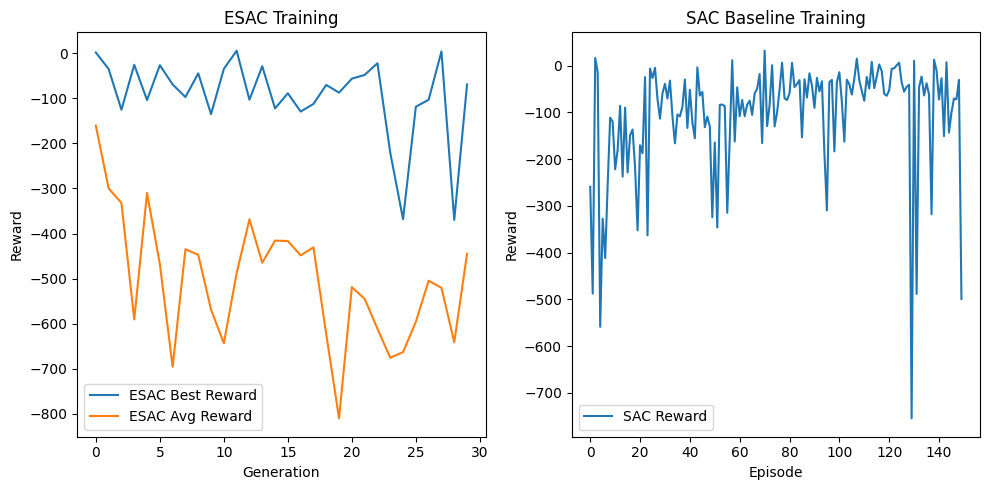

Generating policy animation...


/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


AttributeError: 'GaussianPolicy' object has no attribute 'select_action'

In [6]:
# %% [code]
import gym
import time
import random
import pickle as pkl
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import scipy.stats as ss
from collections import deque
import matplotlib.pyplot as plt
import imageio
from IPython.display import HTML

# Set device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# --------------------------
# Utility functions
# --------------------------
def dm_wrap(obs, wrap=False):
    # Dummy wrapper (for compatibility)
    return obs

def soft_update(target, source, tau):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

def hard_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)

# Simple Replay Buffer for SAC
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

# --------------------------
# Model definitions
# --------------------------
# QNetwork with twin Q-networks for SAC
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=256):
        super(QNetwork, self).__init__()
        # Q1 architecture
        self.q1_fc1 = nn.Linear(state_dim + action_dim, hidden_size)
        self.q1_fc2 = nn.Linear(hidden_size, hidden_size)
        self.q1_out = nn.Linear(hidden_size, 1)
        # Q2 architecture
        self.q2_fc1 = nn.Linear(state_dim + action_dim, hidden_size)
        self.q2_fc2 = nn.Linear(hidden_size, hidden_size)
        self.q2_out = nn.Linear(hidden_size, 1)

    def forward(self, state, action):
        xu = torch.cat([state, action], dim=1)
        # Q1 forward
        x1 = F.relu(self.q1_fc1(xu))
        x1 = F.relu(self.q1_fc2(x1))
        q1 = self.q1_out(x1)
        # Q2 forward
        x2 = F.relu(self.q2_fc1(xu))
        x2 = F.relu(self.q2_fc2(x2))
        q2 = self.q2_out(x2)
        return q1, q2

# Gaussian Policy for SAC (and used also for the ES population)
class GaussianPolicy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size, action_space, log_std_min=-20, log_std_max=2):
        super(GaussianPolicy, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        # Output layers for distribution parameters
        self.mean = nn.Linear(hidden_size, action_dim)
        self.log_std = nn.Linear(hidden_size, action_dim)
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

        # Register buffers for action scaling (to map [-1,1] output to env range)
        self.register_buffer("action_scale", torch.FloatTensor((action_space.high - action_space.low) / 2.))
        self.register_buffer("action_bias", torch.FloatTensor((action_space.high + action_space.low) / 2.))

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mean = self.mean(x)
        log_std = self.log_std(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        return mean, log_std

    def sample(self, state):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()  # reparameterization trick
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_pi = normal.log_prob(x_t) - torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6)
        log_pi = log_pi.sum(1, keepdim=True)
        # Return sampled action, its log probability, and the mean action (for evaluation)
        return action, log_pi, torch.tanh(mean)

# Deterministic Policy for SAC (if needed)
class DeterministicPolicy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size, action_space):
        super(DeterministicPolicy, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_dim)

        self.register_buffer("action_scale", torch.FloatTensor((action_space.high - action_space.low) / 2.))
        self.register_buffer("action_bias", torch.FloatTensor((action_space.high + action_space.low) / 2.))

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        action = torch.tanh(self.fc3(x))
        action = action * self.action_scale + self.action_bias
        return action

# --------------------------
# SAC Agent
# --------------------------
class SAC:
    def __init__(self, state_dim, action_space, args):
        self.gamma = args.gamma
        self.tau = args.tau
        self.alpha = args.alpha
        self.policy_type = args.policy  # "Gaussian" or "Deterministic"
        self.target_update_interval = args.target_update_interval
        self.automatic_entropy_tuning = args.automatic_entropy_tuning
        self.device = device

        self.critic = QNetwork(state_dim, action_space.shape[0], args.hidden_size).to(self.device)
        self.critic_optim = optim.Adam(self.critic.parameters(), lr=args.lr)

        self.critic_target = QNetwork(state_dim, action_space.shape[0], args.hidden_size).to(self.device)
        hard_update(self.critic_target, self.critic)

        if self.policy_type == "Gaussian":
            if self.automatic_entropy_tuning:
                self.target_entropy = -np.prod(action_space.shape).item()
                self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
                self.alpha_optim = optim.Adam([self.log_alpha], lr=args.lr)
            self.policy = GaussianPolicy(state_dim, action_space.shape[0], args.hidden_size, action_space).to(self.device)
        else:
            self.alpha = 0
            self.automatic_entropy_tuning = False
            self.policy = DeterministicPolicy(state_dim, action_space.shape[0], args.hidden_size, action_space).to(self.device)

        self.policy_optim = optim.Adam(self.policy.parameters(), lr=args.lr)

    def select_action(self, state, evaluate=False):
        state = torch.FloatTensor(state).to(self.device).unsqueeze(0)
        if self.policy_type == "Gaussian":
            action, _, mean_action = self.policy.sample(state)
            action = mean_action if evaluate else action
        else:
            action = self.policy(state)
        return action.detach().cpu().numpy()[0]

    def update_parameters(self, memory, batch_size, updates):
        state_batch, action_batch, reward_batch, next_state_batch, mask_batch = memory.sample(batch_size)
        state_batch = torch.FloatTensor(state_batch).to(self.device)
        next_state_batch = torch.FloatTensor(next_state_batch).to(self.device)
        action_batch = torch.FloatTensor(action_batch).to(self.device)
        reward_batch = torch.FloatTensor(reward_batch).to(self.device).unsqueeze(1)
        mask_batch = torch.FloatTensor(mask_batch).to(self.device).unsqueeze(1)

        with torch.no_grad():
            next_state_action, next_state_log_pi, _ = self.policy.sample(next_state_batch)
            qf1_next_target, qf2_next_target = self.critic_target(next_state_batch, next_state_action)
            min_qf_next_target = torch.min(qf1_next_target, qf2_next_target) - self.alpha * next_state_log_pi
            next_q_value = reward_batch + mask_batch * self.gamma * min_qf_next_target

        qf1, qf2 = self.critic(state_batch, action_batch)
        qf1_loss = F.mse_loss(qf1, next_q_value)
        qf2_loss = F.mse_loss(qf2, next_q_value)

        self.critic_optim.zero_grad()
        (qf1_loss + qf2_loss).backward()
        self.critic_optim.step()

        pi, log_pi, _ = self.policy.sample(state_batch)
        min_qf_pi = torch.min(*self.critic(state_batch, pi))
        policy_loss = ((self.alpha * log_pi) - min_qf_pi).mean()

        self.policy_optim.zero_grad()
        policy_loss.backward()
        self.policy_optim.step()

        if self.automatic_entropy_tuning:
            alpha_loss = -(self.log_alpha * (log_pi + self.target_entropy).detach()).mean()
            self.alpha_optim.zero_grad()
            alpha_loss.backward()
            self.alpha_optim.step()
            self.alpha = self.log_alpha.exp()
        else:
            alpha_loss = torch.tensor(0.).to(self.device)

        if updates % self.target_update_interval == 0:
            soft_update(self.critic_target, self.critic, self.tau)

        return qf1_loss.item(), qf2_loss.item(), policy_loss.item(), alpha_loss.item(), self.alpha.item()

# --------------------------
# Evolutionary Strategy functions (using GaussianPolicy)
# --------------------------
def crossover(args, state_dim, action_dim, gene1, gene2, action_space):
    actor1 = GaussianPolicy(state_dim, action_dim, args.hidden_size, action_space).to(device)
    actor2 = GaussianPolicy(state_dim, action_dim, args.hidden_size, action_space).to(device)
    actor1.load_state_dict(gene1)
    actor2.load_state_dict(gene2)
    for p1, p2 in zip(actor1.parameters(), actor2.parameters()):
        if p1.data.dim() > 1:  # only crossover weights (not biases)
            mask = torch.rand_like(p1) < 0.5
            new_p1 = torch.where(mask, p1.data, p2.data)
            new_p2 = torch.where(mask, p2.data, p1.data)
            p1.data.copy_(new_p1)
            p2.data.copy_(new_p2)
    return actor2.state_dict()

def sample_noise(neural_net):
    return [np.random.normal(size=p.shape) for p in neural_net.parameters()]

def evaluate_neuralnet(nn_model, env, wrap, evaluate=True):
    obs = dm_wrap(env.reset(), wrap=wrap)
    total_reward = 0
    done = False
    while not done:
        obs_tensor = torch.FloatTensor(obs).to(device)
        with torch.no_grad():
            # Use the policy's sample method if available
            if hasattr(nn_model, 'sample'):
                _, _, mean_action = nn_model.sample(obs_tensor.unsqueeze(0))
                action = mean_action.cpu().numpy()[0]
            else:
                action = torch.clamp(nn_model(obs_tensor), -1, 1).cpu().numpy()
        next_obs, reward, done, _ = env.step(action)
        obs = dm_wrap(next_obs, wrap=wrap)
        total_reward += reward
    return total_reward

def evaluate_noisy_net(std_noise, noise, neural_net, env, wrap):
    old_dict = neural_net.state_dict()
    for param, n in zip(neural_net.parameters(), noise):
        param.data.add_(torch.tensor(n * std_noise, device=device, dtype=param.data.dtype))
    reward = evaluate_neuralnet(neural_net, env, wrap)
    neural_net.load_state_dict(old_dict)  # restore
    return reward

def normalized_rank(rewards):
    ranked = ss.rankdata(rewards)
    norm = (ranked - 1) / (len(ranked) - 1)
    norm -= 0.5
    return norm

# --------------------------
# Hyperparameters and arguments
# --------------------------
class Args:
    def __init__(self):
        self.env = "LunarLanderContinuous-v2"  # change to LunarLanderContinuous-v2
        self.hidden_size = 256
        self.gamma = 0.99
        self.tau = 0.005
        self.alpha = 0.2
        self.lr = 3e-4
        self.policy = "Gaussian"  # or "Deterministic"
        self.target_update_interval = 1
        self.automatic_entropy_tuning = True
        # ES-specific parameters
        self.population_size = 10
        self.elite_fraction = 0.2
        self.std_noise = 0.1
        # SAC update frequency in ESAC
        self.sac_update_steps = 10

args = Args()

# --------------------------
# Training loops
# --------------------------
def train_ESAC(num_generations=30):
    """
    ESAC: Hybrid evolutionary strategy with periodic SAC updates.
    """
    env = gym.make(args.env)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    wrap = False  # adjust if necessary

    # Initialize ES population (using GaussianPolicy)
    population = [GaussianPolicy(state_dim, action_dim, args.hidden_size, env.action_space).to(device)
                  for _ in range(args.population_size)]
    population_params = [ind.state_dict() for ind in population]

    # Initialize SAC agent
    sac_agent = SAC(state_dim, env.action_space, args)
    replay_buffer = ReplayBuffer(capacity=10000)

    best_rewards = []
    avg_rewards = []

    for gen in range(num_generations):
        gen_rewards = []
        for i, ind in enumerate(population):
            ind.load_state_dict(population_params[i])
            r = evaluate_neuralnet(ind, env, wrap)
            gen_rewards.append(r)
        # Evaluate SAC agent's policy as an extra candidate
        sac_reward = evaluate_neuralnet(sac_agent.policy, env, wrap)
        gen_rewards.append(sac_reward)
        population_params.append(sac_agent.policy.state_dict())

        best_rewards.append(np.max(gen_rewards))
        avg_rewards.append(np.mean(gen_rewards))
        print(f"Generation {gen}: Best Reward = {best_rewards[-1]:.2f}, Avg Reward = {avg_rewards[-1]:.2f}")

        fitness = normalized_rank(np.array(gen_rewards))
        new_population_params = []
        num_elite = max(1, int(args.elite_fraction * len(population_params)))
        elite_indices = np.argsort(gen_rewards)[-num_elite:]
        elites = [population_params[i] for i in elite_indices]

        for i in range(args.population_size):
            base_model = GaussianPolicy(state_dim, action_dim, args.hidden_size, env.action_space).to(device)
            base_model.load_state_dict(population_params[i])
            noise = sample_noise(base_model)
            r_pos = evaluate_noisy_net(args.std_noise, noise, base_model, env, wrap)
            r_neg = evaluate_noisy_net(args.std_noise, [-n for n in noise], base_model, env, wrap)
            if r_pos > r_neg:
                for param, n in zip(base_model.parameters(), noise):
                    param.data.add_(torch.tensor(n * args.std_noise, device=device, dtype=param.data.dtype))
            else:
                for param, n in zip(base_model.parameters(), noise):
                    param.data.add_(torch.tensor(-n * args.std_noise, device=device, dtype=param.data.dtype))
            elite_candidate = random.choice(elites)
            new_params = crossover(args, state_dim, action_dim, base_model.state_dict(), elite_candidate, env.action_space)
            new_population_params.append(new_params)

        population_params = new_population_params

        # SAC update
        if gen % args.sac_update_steps == 0:
            for _ in range(5):  # run 5 episodes for SAC update
                state = env.reset()
                done = False
                while not done:
                    action = sac_agent.select_action(state)
                    next_state, reward, done, _ = env.step(action)
                    replay_buffer.push(state, action, reward, next_state, float(not done))
                    state = next_state
                if len(replay_buffer) > 64:
                    sac_agent.update_parameters(replay_buffer, batch_size=64, updates=gen)
            # Inject SAC policy into population
            population_params[0] = sac_agent.policy.state_dict()

    env.close()
    return best_rewards, avg_rewards

def train_SAC_baseline(num_episodes=150):
    """
    Pure SAC baseline training.
    """
    env = gym.make(args.env)
    state_dim = env.observation_space.shape[0]
    sac_agent = SAC(state_dim, env.action_space, args)
    replay_buffer = ReplayBuffer(capacity=10000)

    rewards_per_episode = []
    for ep in range(num_episodes):
        state = env.reset()
        ep_reward = 0
        done = False
        while not done:
            action = sac_agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            replay_buffer.push(state, action, reward, next_state, float(not done))
            state = next_state
            ep_reward += reward
            if len(replay_buffer) > 64:
                sac_agent.update_parameters(replay_buffer, batch_size=64, updates=ep)
        rewards_per_episode.append(ep_reward)
        if ep % 10 == 0:
            print(f"SAC Episode {ep}: Reward = {ep_reward:.2f}")
    env.close()
    return sac_agent, rewards_per_episode

# --------------------------
# Visualization function
# --------------------------
def visualize_policy(policy, env_name="LunarLanderContinuous-v2", filename="lunarlander.mp4"):
    """
    Run one episode using the given policy, record frames, and save as a video.
    Returns HTML to display the video.
    """
    env = gym.make(env_name)
    frames = []
    state = env.reset()
    done = False
    while not done:
        frame = env.render(mode="rgb_array")
        frames.append(frame)
        action = policy.select_action(state, evaluate=True)
        state, reward, done, _ = env.step(action)
    env.close()
    imageio.mimsave(filename, frames, fps=30)
    return HTML(f"""
    <video width="600" height="400" controls>
      <source src="{filename}" type="video/mp4">
    </video>
    """)

# --------------------------
# Main execution: training and visualization
# --------------------------
def main():
    # Train ESAC (for demonstration, fewer generations)
    print("Training ESAC (Evolution + SAC) ...")
    esac_best, esac_avg = train_ESAC(num_generations=30)

    # Train pure SAC baseline and retrieve the trained agent
    print("\nTraining SAC baseline ...")
    sac_agent, sac_rewards = train_SAC_baseline(num_episodes=150)

    # Plot training curves
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(esac_best, label="ESAC Best Reward")
    plt.plot(esac_avg, label="ESAC Avg Reward")
    plt.xlabel("Generation")
    plt.ylabel("Reward")
    plt.title("ESAC Training")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(sac_rewards, label="SAC Reward")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("SAC Baseline Training")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Visualize the trained SAC policy on LunarLanderContinuous-v2
    print("Generating policy animation...")
    video = visualize_policy(sac_agent.policy, env_name=args.env, filename="lunarlander.mp4")
    display(video)

if __name__=="__main__":
    main()
